In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools

In [9]:
# 1️⃣  Start fresh: wipe all nested clones
!rm -rf CodexFun

# 2️⃣  Clone just once
!git clone https://github.com/rpmiller4/CodexFun.git
%cd CodexFun

# 3️⃣  Make sure THIS folder is first on PYTHONPATH
import sys, os, importlib
sys.path.insert(0, os.getcwd())    # put ./CodexFun at front

# 4️⃣  Import and RELOAD to flush any stale version from memory
import synthetic_market as sm
importlib.reload(sm)

# 5️⃣  Sanity check
print("run_simulation_multi present? ->", hasattr(sm, "run_simulation_multi"))


Cloning into 'CodexFun'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 201 (delta 30), reused 0 (delta 0), pack-reused 129 (from 1)
Receiving objects: 100% (201/201), 102.66 KiB | 3.80 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/CodexFun/CodexFun
run_simulation_multi present? -> True


In [11]:
!git clone https://github.com/rpmiller4/CodexFun.git
%cd CodexFun

import synthetic_market as sm

Cloning into 'CodexFun'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 201 (delta 30), reused 0 (delta 0), pack-reused 129 (from 1)
Receiving objects: 100% (201/201), 102.66 KiB | 5.70 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/CodexFun/CodexFun/CodexFun/CodexFun


In [12]:
import synthetic_market as sm

# Genetic Algorithm Optimization of Credit Spreads
This notebook searches for the best parameter set for `synthetic_market.run_simulation()` using a genetic algorithm.

The genetic algorithm explores a small range of strategy parameters. Fitness is defined as total return minus maximum drawdown.

In [13]:
SEARCH_BOUNDS = dict(
    ema_period =(20, 100), # int
    risk_fraction =(0.01, 0.30),# float
    short_leg_low =(5, 20), # float (min distance)
    short_leg_high =(10, 30), # float (max distance, must ≥ low)
    spread_w_low =(1, 5), # int
    spread_w_high =(4, 10), # int (≥ low)
    trade_credit_ratio=(0.2, 0.5), # float
)

In [14]:
REALISM = {
    "slippage":   True,
    "liquidity":  True,
    "margin":     True,
    "jumps":      True,
    # add more when implemented:
    # "iv_pricing": True,
    # "mtm":        True,
}


In [15]:
random.seed(0)
np.random.seed(0)

creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

def gen_ind():
    b = SEARCH_BOUNDS
    return creator.Individual([
        np.random.randint(b['ema_period'][0], b['ema_period'][1] + 1),
        np.random.uniform(*b['risk_fraction']),
        np.random.uniform(*b['short_leg_low']),
        np.random.uniform(*b['short_leg_high']),
        np.random.randint(b['spread_w_low'][0], b['spread_w_low'][1] + 1),
        np.random.randint(b['spread_w_high'][0], b['spread_w_high'][1] + 1),
        np.random.uniform(*b['trade_credit_ratio']),
    ])

def mate(i1, i2):
    tools.cxOnePoint(i1, i2)
    return i1, i2

def mutate(ind):
    ind[0] = int(np.clip(ind[0] + int(random.gauss(0,5)), *SEARCH_BOUNDS['ema_period']))
    ind[1] = float(np.clip(ind[1] + random.gauss(0,0.005), *SEARCH_BOUNDS['risk_fraction']))
    ind[2] = float(np.clip(ind[2] + random.gauss(0,1), *SEARCH_BOUNDS['short_leg_low']))
    ind[3] = float(np.clip(ind[3] + random.gauss(0,1), *SEARCH_BOUNDS['short_leg_high']))
    ind[4] = int(np.clip(ind[4] + int(random.gauss(0,1)), *SEARCH_BOUNDS['spread_w_low']))
    ind[5] = int(np.clip(ind[5] + int(random.gauss(0,1)), *SEARCH_BOUNDS['spread_w_high']))
    ind[6] = float(np.clip(ind[6] + random.gauss(0,0.02), *SEARCH_BOUNDS['trade_credit_ratio']))
    if ind[3] < ind[2]:
        ind[3] = ind[2]
    if ind[5] < ind[4]:
        ind[5] = ind[4]
    return (ind,)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [16]:
def eval_ind(ind):
    # Extract genome
    short_low,  short_high  = float(ind[2]), float(ind[3])
    spread_low, spread_high = int(ind[4]),   int(ind[5])

    # Basic validity checks
    if short_high <= short_low or spread_high < spread_low:
        return (-1e9,)          # penalise invalid individual

    # Build strategy config
    cfg = {
        "ema_period":       int(ind[0]),
        "risk_fraction":    ind[1],
        "short_leg_distance": (short_low, short_high),
        "spread_width_range": (spread_low, spread_high),
        "trade_credit_ratio": ind[6],
        "realism": REALISM,
    }

    # Ensemble fitness over 5 seeds
    stats  = sm.run_simulation_multi(cfg, seeds=range(5))
    score  = stats["total_return"].mean() - stats["max_drawdown"].mean()
    return (score,)


In [17]:
toolbox = base.Toolbox()
toolbox.register('individual', gen_ind)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('mate', mate)
toolbox.register('mutate', mutate)
toolbox.register('select', tools.selTournament, tournsize=3)
toolbox.register('evaluate', eval_ind)

POP = 40
GENS = 25
CX = 0.5
MUT = 0.3

pop = toolbox.population(n=POP)
best_scores = []

for g in range(GENS):
    fits = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fits):
        ind.fitness.values = fit
    best = tools.selBest(pop, 1)[0]
    best_scores.append(best.fitness.values[0])

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for c1, c2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CX:
            toolbox.mate(c1, c2)
            del c1.fitness.values, c2.fitness.values

    for ind in offspring:
        if random.random() < MUT:
            toolbox.mutate(ind)
            del ind.fitness.values

    invalid = [ind for ind in offspring if not ind.fitness.valid]
    fits = map(toolbox.evaluate, invalid)
    for ind, fit in zip(invalid, fits):
        ind.fitness.values = fit

    pop[:] = offspring

champ = tools.selBest(pop, 1)[0]

In [18]:
# 1. Fresh clone or pull
!rm -rf CodexFun                 # optional: wipe old copy
!git clone https://github.com/rpmiller4/CodexFun.git
%cd CodexFun

# 2. Make sure this folder is first on PYTHONPATH
import sys, os
sys.path.insert(0, os.getcwd())

# 3. Import and force-reload to pick up the newest functions
import importlib, synthetic_market as sm
importlib.reload(sm)

# 4. Confirm attribute exists
print("Has run_simulation_multi:", hasattr(sm, "run_simulation_multi"))


Cloning into 'CodexFun'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 201 (delta 30), reused 0 (delta 0), pack-reused 129 (from 1)
Receiving objects: 100% (201/201), 102.66 KiB | 4.46 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/CodexFun/CodexFun/CodexFun/CodexFun/CodexFun
Has run_simulation_multi: True


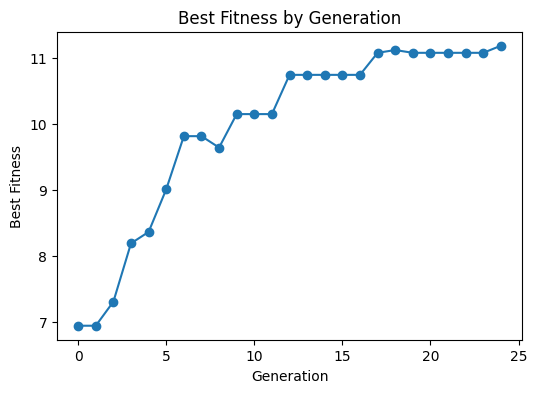

Win-rate  mean : 81.0 %
Win-rate  std  : 8.4 %
Total-return mean : 995.5 %
Total-return std  : 332.7 %
CAGR approx       : 82.0 %


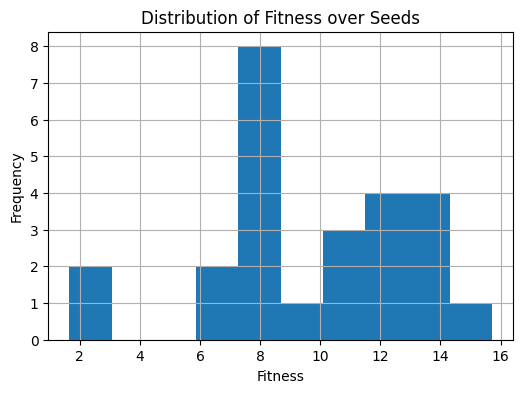

Champion params: {'ema_period': 55, 'risk_fraction': 0.22746721604166117, 'short_leg_distance': (8.569516825804271, 15.95732894816073), 'spread_width_range': (5, 10), 'trade_credit_ratio': 0.5, 'realism': {'slippage': True, 'liquidity': True, 'margin': True, 'jumps': True}}
Score mean: 9.6236
Score std: 3.4138


In [24]:
plt.figure(figsize=(6,4))
plt.plot(best_scores, marker='o')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness by Generation')
plt.show()

champ_cfg = {
    "ema_period": int(champ[0]),
    "risk_fraction": champ[1],
    "short_leg_distance": (champ[2], champ[3]),
    "spread_width_range": (int(champ[4]), int(champ[5])),
    "trade_credit_ratio": champ[6],
    "realism": REALISM,
}

# --- new lines ---
print("Win-rate  mean :", round(results["win_rate"].mean()*100, 1), "%")
print("Win-rate  std  :", round(results["win_rate"].std()*100, 1), "%")

print("Total-return mean :", round(results["total_return"].mean()*100, 1), "%")
print("Total-return std  :", round(results["total_return"].std()*100, 1), "%")
# -------------------

from datetime import datetime
start  = datetime.strptime(sm.DEFAULT_CONFIG["start_date"], "%Y-%m-%d")
end    = datetime.strptime(sm.DEFAULT_CONFIG["end_date"],   "%Y-%m-%d")
years  = (end - start).days / 365.25          # ≈ 4-year span

cagr   = (results["total_return"].mean() + 1) ** (1 / years) - 1
print("CAGR approx       :", round(cagr*100, 1), "%")



results = sm.run_simulation_multi(champ_cfg, seeds=list(range(25)))
results['score'] = results['total_return'] - results['max_drawdown']
results['score'].hist(figsize=(6,4))
plt.title('Distribution of Fitness over Seeds')
plt.xlabel('Fitness')
plt.ylabel('Frequency')
plt.show()

print('Champion params:', champ_cfg)
print('Score mean:', round(results['score'].mean(), 4))
print('Score std:', round(results['score'].std(), 4))

## Champion Parameters
- `ema_period`: ...
- `risk_fraction`: ...
- `short_leg_distance`: ...
- `spread_width_range`: ...
- `trade_credit_ratio`: ...